# Logistic Regression Using Optim.jl

## Logistic Regression

A major focus in Machine Learning is classification problem where we want to predict which category a certain object belongs to. For example, we might be interested whether an email is spam or not, which number does a picture show, whether a credit card holder will default or not, etc.

For the credit card case, the intuition is that we want to know the probability that card holder $i$ will default, namely $\pi_{i}$, based on account balance, income, etc. The more certain we are, the closer the output is to 1. If we use Linear Regression, $\pi_{i}$ may be lager than 1 and is certainly not true. Logistic Regression is thus introduced which has the form

$$
\pi_{i} = \frac{e^{\beta_0+\beta_1x_{1i}+\beta_2x_{2i}}}{1+e^{\beta_0+\beta_1x_{1i}+\beta_2x_{2i}}}
$$

The function has an "S" shape ranging from 0 to 1 as shown below.

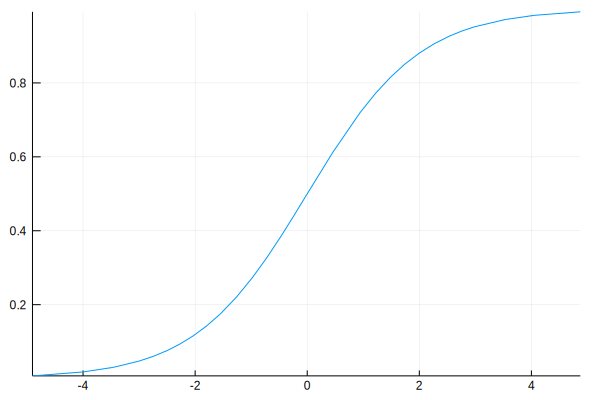

In [1]:
# in case you hadn't installed the package
# Pkg.update()
# Pkg.add("Plots")
using Plots; gr()
plot(x->e^x/(1+e^x), legend=false)

In vector form, the function becomes 

$$
\pi_{i} = \frac{e^{\mathbf{x_i}^T\beta}}{1+e^{\mathbf{x_i}^T\beta}} = \frac{1}{1+e^{-\mathbf{x_i}^T\beta}}
$$

where

$$
\mathbf{x_i} = \begin{bmatrix}
       1    \\
       x_{1i} \\
       x_{2i} \\ 
      \end{bmatrix}
\quad \beta = \begin{bmatrix}
               \beta_0 \\
               \beta_1 \\
               \beta_2 \\ 
              \end{bmatrix}
$$

## Maximum Likelihood Estimation

We use maximum likelihood estimation to estimate the parameters ($\beta$), we need find the parameters that maximize the likelihood function given the data we have. Assuming the sample size is $n$ and the data is i.i.d, the likelihood function is

$$
\begin{align*}
p\left(y, \mathbf{X}  \mid  \beta \right) &=\prod_{i:y=1}\pi_{i}\prod_{i:y=o}(1-\pi_{i})\\
                                          &=\prod_{i=1}^{n}\pi_{i}^{y_{i}}(1-\pi_{i})^{1-y_{i}}\\
\end{align*}
$$

Therefore the log likelihood function is

$$
\begin{align*} 
\ell(\beta)&=\sum_{i=1}^{n}[y_{i}\log(\pi_{i})+(1-y_{i})\log(1-\pi_{i})]\\ 
& = \sum_{i=1}^{n}[y_{i}\mathbf{x_i}^T\beta - \log(1+e^{\mathbf{x_i}^T\beta})]
\end{align*}
$$

Because `Optim.jl` is used to **minimize** a function, the objective function becomes **negative** log likelihood function.

$$
\underset{\beta}{\text{minimize}} \quad f(\beta) = -\ell(\beta) = \sum_{i=1}^{n}[\log(1+e^{\mathbf{x_i}^T\beta}) - y_{i}\mathbf{x_i}^T\beta]
$$

To transform the objective function into code, note that `X` is $n$ rows of $\mathbf{x_i}^T$ and operators with dot(.) are element-wise.

$$
\texttt{X} = \begin{bmatrix}
        1      & x_{11} & x_{21} \\
        1      & x_{12} & x_{22} \\
        \vdots & \vdots & \vdots\\
        1      & x_{1n} & x_{2n} \\ 
        \end{bmatrix}
$$

$$
\texttt{X*β} = \begin{bmatrix}
        \beta_0 + \beta_1 x_{11} + \beta_2 x_{21} \\
        \vdots \\
        \beta_0 + \beta_1 x_{1n} + \beta_2 x_{2n} \\ 
        \end{bmatrix}
$$

In [2]:
f(β) = sum(log.(1 .+ e.^(X * β)) - y .* (X * β))

f (generic function with 1 method)

## Performing Regression
Now it's time to perform Logistic Regression on the credit card data from ["An Introduction to Statistical Learning with Applications in R"](http://www-bcf.usc.edu/~gareth/ISL/data.html). For this example, we are only interested in the effects of `Balance` as $x_1$ and `Income` as $x_2$ on non-students. Before we start regression, we need prepare our data.

In [25]:
# Pkg.add("RDatasets")
using RDatasets
credit = dataset("ISLR", "Default")
non_student = credit[credit[:Student] .== "No", :] # select non-students
head(non_student)

,Default,Student,Balance,Income
1,No,No,729.526,44361.6
2,No,No,1073.55,31767.1
3,No,No,529.251,35704.5
4,No,No,785.656,38463.5
5,No,No,825.513,24905.2
6,No,No,1161.06,37468.5


In [26]:
X = hcat(ones(Int8, size(non_student)[1]), non_student[3], non_student[4]) # add 1 as the first column
y = Array(recode(non_student[1], "Yes"=>1, "No"=>0)) # recode categorical data into number 1 or 0

7056-element Array{Int64,1}:
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 ⋮
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0
 0

### Gradient Free Methods
Now we can use `Optim.jl` to estimate $\beta$. Note that we need pass an array of initial values of `β`. In the example the initial value is `[0.0,0.0,0.0]`. If we don't pass the gradient function, `Optim.jl` will use methods that don't require gradient infomation. The default method is Nelder-Mead, also known as downhill simplex method, which applies a moving simplex to search the designed space untill it reaches a speciﬁed error tolerence.

In [5]:
#Pkg.add("Optim")
using Optim

In [6]:
optimize(f, zeros(3)) # equal to optimize(f, zeros(3), NelderMead())

Results of Optimization Algorithm
 * Algorithm: Nelder-Mead
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-10.9369799553686,0.005817604688126401, ...]
 * Minimum: 5.040173e+02
 * Iterations: 215
 * Convergence: true
   *  √(Σ(yᵢ-ȳ)²)/n < 1.0e-08: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 389

Another gradient free method is Simulated Annealing. The main idea is that, instead of searching and staying at local minima, the point has probability $exp(\frac{-\Delta f}{kT})$ to move out of it. In our example, the method doesn't provide a good result, the point even stays at the initial value, we will discuss this in the next part.

In [7]:
optimize(f, zeros(3), SimulatedAnnealing())

Results of Optimization Algorithm
 * Algorithm: Simulated Annealing
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.0,0.0,0.0]
 * Minimum: 4.890847e+03
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = NaN 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = NaN |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = NaN 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1001

If we ask `Optim.jl` to perform a gradient-required method, such as Gradient Descent, without passing the gradient function, `Optim.jl` will provide an approximate gradient and apply the gradient required method.

In [8]:
optimize(f, zeros(3), GradientDescent()) 

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-1.6940577768955823e-6,0.00209726073510965, ...]
 * Minimum: 8.742771e+02
 * Iterations: 26
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 3.77e-08 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.00e-06 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.00e+04 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 222
 * Gradient Calls: 222

### Why Simulated Annealing Method Fails?

As we can see above, the point didn't move at all using Simulated Annealing method. The reason is that as the point moves around, $-\Delta f(x)$ is too large that the probability of moving out, $exp(\frac{-\Delta f}{kT})$, is nearly zero.

In [9]:
f([0.0, 0.0, 0.0])

4890.846506030983

In [10]:
f([0.0, 0.01, 0.01])

Inf

Passing the initial value `[[0.0, 0.0, 0.0]`, the result is around `6931`. If we adjust the parameters a little bit, we will get `Inf`. The point "moves too much".

`Optim.jl` uses the function `default_neighbor!` to decide how the point moves. 

```Julia
function default_neighbor!(x::AbstractArray, x_proposal::AbstractArray)
    @assert size(x) == size(x_proposal)
    for i in 1:length(x)
        @inbounds x_proposal[i] = x[i] + randn()
    end
    return
end
```

As we can see, the point moves `randn()` in each direction, which is too large. We can define a new `neighbor!` function to make the point travel less.

In [11]:
function neighbor!(x::AbstractArray, x_proposal::AbstractArray)
    @assert size(x) == size(x_proposal)
    for i in 1:length(x)
        @inbounds x_proposal[i] = x[i] + randn()/10
    end
end

neighbor! (generic function with 1 method)

In [12]:
optimize(f, zeros(3), SimulatedAnnealing(neighbor = neighbor!))

Results of Optimization Algorithm
 * Algorithm: Simulated Annealing
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [0.0,0.0,0.0]
 * Minimum: 4.890847e+03
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = NaN 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = NaN |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = NaN 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1001

Although the result is still not ideal, at least it's better than staying at the initial value.

### Gradient Required Methods
We can move to gradient required methods by providing gradient information.

$$
\nabla f(\beta) = \begin{bmatrix}
           \frac{\partial f}{\partial \beta_0}   \\
           \frac{\partial f}{\partial \beta_1} \\
           \frac{\partial f}{\partial \beta_2} \\ 
           \end{bmatrix}
         = \begin{bmatrix}
           \sum_{i=1}^{n} e^{\mathbf{x_i}^T\beta}/(1+e^{\mathbf{x_i}^T\beta}) - y_i \\
           \sum_{i=1}^{n} x_{1i}e^{\mathbf{x_i}^T\beta}/(1+e^{\mathbf{x_i}^T\beta}) - y_ix_{1i}      \\
           \sum_{i=1}^{n} x_{2i}e^{\mathbf{x_i}^T\beta}/(1+e^{\mathbf{x_i}^T\beta}) - y_ix_{2i}      \\ 
           \end{bmatrix}
         = \begin{bmatrix}
           \sum_{i=1}^{n} (1+e^{-\mathbf{x_i}^T\beta})^{-1} - y_i \\
           \sum_{i=1}^{n} x_{1i}(1+e^{-\mathbf{x_i}^T\beta})^{-1} - y_ix_{1i}      \\
           \sum_{i=1}^{n} x_{2i}(1+e^{-\mathbf{x_i}^T\beta})^{-1} - y_ix_{2i}      \\ 
           \end{bmatrix}
$$

We put exclamation mark(!) at the end of the function name because we make modifications on the `storage` vector variable, or you can call it `gradient` variable. After each iteration, the `storage` variable will change as the value of `β` changes, we only need transform each entry of $\nabla f(\beta)$ into code. 

In [13]:
function g!(storage, β)
    storage[1]= sum((1 .+ e.^(-X * β)).^-1 - y)
    storage[2]= sum(X[:,2]./(1 .+ e.^(-X * β)) - y.*X[:,2])
    storage[3]= sum(X[:,3]./(1 .+ e.^(-X * β)) - y.*X[:,3])
end

g! (generic function with 1 method)

The default method is L-BFGS which is limited memory version of BFGS.

In [14]:
optimize(f, g!, zeros(3))  # equal to optimize(f, g!, zeros(3), LBFGS())

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-10.936996147926969,0.00581761412461086, ...]
 * Minimum: 5.040173e+02
 * Iterations: 23
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.85e-10 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.13e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.33e-10 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 148
 * Gradient Calls: 148

The BFGS method uses gradient to approxiamate the Hessian and apply Newton's method.

In [15]:
optimize(f, g!, zeros(3), BFGS())

Results of Optimization Algorithm
 * Algorithm: BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-10.936996147644159,0.005817614124717566, ...]
 * Minimum: 5.040173e+02
 * Iterations: 16
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.32e-12 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.13e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 1.28e-09 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 116
 * Gradient Calls: 116

`Optim.jl` can also apply Gradient Descent method and Conjugate Gradient Descent method.

In [16]:
optimize(f, g!, zeros(3), GradientDescent())

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-1.1722447127568948e-6,0.0015699471334478488, ...]
 * Minimum: 8.868502e+02
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 3.38e-07 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.46e-05 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 4.08e+04 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 2616
 * Gradient Calls: 2616

In [17]:
optimize(f, g!, zeros(3), ConjugateGradient())

Results of Optimization Algorithm
 * Algorithm: Conjugate Gradient
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-11.565274126641834,0.006073747862744703, ...]
 * Minimum: 5.045925e+02
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 6.55e-06 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 5.50e-10 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.04e+02 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 2135
 * Gradient Calls: 1373

The result tells us that the algorithm stops because it reached maximum number of iterations (1000), we can adjust the value of iterations by [changing configurable options](http://julianlsolvers.github.io/Optim.jl/stable/user/config/). 

In [18]:
optimize(f, g!, zeros(3), GradientDescent(), Optim.Options(iterations = 10000))

Results of Optimization Algorithm
 * Algorithm: Gradient Descent
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-1.049531296428253e-5,0.0022618381882457805, ...]
 * Minimum: 8.735567e+02
 * Iterations: 10000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 8.74e-10 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 9.96e-11 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 1.02e+02 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 25179
 * Gradient Calls: 25179

### Hessian Required Methods

`Optim.jl` can apply Newton's method if we provide the Hessian. This method is regarded as the gold standard of unconstrained smooth optimization, though it could be painful to calculate the Hessian.

$$
\mathbf{H}f(\beta) = \begin{bmatrix}
              \frac{\partial}{\partial \beta_0}   \\
              \frac{\partial}{\partial \beta_1} \\
              \frac{\partial}{\partial \beta_2} \\ 
              \end{bmatrix}
              \begin{bmatrix} 
              \frac{\partial f}{\partial \beta_0} \ \frac{\partial f}{\partial \beta_1} \ \frac{\partial f}{\partial \beta_2}
              \end{bmatrix}
            = \begin{bmatrix}
              \frac{\partial^2 f}{\partial \beta_0^2} \ \frac{\partial^2 f}{\partial \beta_0\beta_1} \ \frac{\partial^2 f}{\partial \beta_0\beta_2}\\
              \frac{\partial^2 f}{\partial \beta_0\beta_1} \ \frac{\partial^2 f}{\partial \beta_1^2} \ \frac{\partial^2 f}{\partial \beta_1\beta_2}\\
              \frac{\partial^2 f}{\partial \beta_0\beta_2} \ \frac{\partial^2 f}{\partial \beta_1\beta_2} \ \frac{\partial^2 f}{\partial \beta_2^2} \\ 
              \end{bmatrix}
            = \begin{bmatrix}
              \sum_{i=1}^{n}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2} & 
              \sum_{i=1}^{n}x_{1i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2} & 
              \sum_{i=1}^{n}x_{2i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2} \\
              \sum_{i=1}^{n}x_{1i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}         & 
              \sum_{i=1}^{n}x_{1i}^2e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}       &
              \sum_{i=1}^{n}x_{1i}x_{2i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}   \\
              \sum_{i=1}^{n}x_{2i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}         &
              \sum_{i=1}^{n}x_{1i}x_{2i}e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}   & 
              \sum_{i=1}^{n}x_{2i}^2e^{-\mathbf{x_i}^T\beta}(1+e^{-\mathbf{x_i}^T\beta})^{-2}       \\ 
              \end{bmatrix}
$$

In [19]:
function h!(storage, β)
    storage[1,1]= sum(e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[1,2]= sum(X[:,2] .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[1,3]= sum(X[:,3] .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[2,2]= sum(X[:,2].^2 .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[2,3]= sum(X[:,2] .* X[:,3] .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
    storage[3,3]= sum(X[:,3].^2 .* e.^(-X * β) .* (1 .+ e.^(-X * β)).^-2)
end

h! (generic function with 1 method)

In [20]:
optimize(f, g!, h!, zeros(3)) # equal to optimize(f, g!, h!, zeros(3), Newton())

Results of Optimization Algorithm
 * Algorithm: Newton's Method
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-10.936995666059834,0.005817613899214999, ...]
 * Minimum: 5.040173e+02
 * Iterations: 290
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 1.41e-07 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: true
     |f(x) - f(x')| = 0.00e+00 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 2.20e-01 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 844
 * Gradient Calls: 844
 * Hessian Calls: 290

If we put some restrictions on Newton's Method, such method is called Newton's Method With a Trust Region.

In [21]:
optimize(f, g!, h!, zeros(3), NewtonTrustRegion())

Results of Optimization Algorithm
 * Algorithm: Newton's Method (Trust Region)
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-9.20575398819707,0.005142584666976512, ...]
 * Minimum: 5.090461e+02
 * Iterations: 1000
 * Convergence: false
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.48e-03 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 2.98e-05 |f(x)|
   * |g(x)| ≤ 1.0e-08: false 
     |g(x)| = 6.12e+00 
   * Stopped by an increasing objective: false
   * Reached Maximum Number of Iterations: true
 * Objective Calls: 1001
 * Gradient Calls: 1001
 * Hessian Calls: 1001

## Obtaining Results
After applying the optimization algorithm, results($\beta$) can be retrived by the following steps. Since the functions are not exported, they have to be prefixed by "`Optim.`".

In [22]:
results = optimize(f, g!, zeros(3))

Results of Optimization Algorithm
 * Algorithm: L-BFGS
 * Starting Point: [0.0,0.0,0.0]
 * Minimizer: [-10.936996147926969,0.00581761412461086, ...]
 * Minimum: 5.040173e+02
 * Iterations: 23
 * Convergence: true
   * |x - x'| ≤ 1.0e-32: false 
     |x - x'| = 2.85e-10 
   * |f(x) - f(x')| ≤ 1.0e-32 |f(x)|: false
     |f(x) - f(x')| = 1.13e-16 |f(x)|
   * |g(x)| ≤ 1.0e-08: true 
     |g(x)| = 2.33e-10 
   * Stopped by an increasing objective: true
   * Reached Maximum Number of Iterations: false
 * Objective Calls: 148
 * Gradient Calls: 148

In [23]:
estimate_β = Optim.minimizer(results)

3-element Array{Float64,1}:
 -10.937     
   0.00581761
   1.59712e-6

We can now compare the results with `GLM.jl` which is dedicated to performe Logistic Regression and other linear models.

In [24]:
# Pkg.add("GLM")
using GLM
lr = glm(@formula(Default ~ Balance + Income), non_student, Binomial(), LogitLink())

StatsModels.DataFrameRegressionModel{GLM.GeneralizedLinearModel{GLM.GlmResp{Array{Float64,1},Distributions.Binomial{Float64},GLM.LogitLink},GLM.DensePredChol{Float64,Base.LinAlg.Cholesky{Float64,Array{Float64,2}}}},Array{Float64,2}}

Formula: Default ~ 1 + Balance + Income

Coefficients:
               Estimate   Std.Error  z value Pr(>|z|)
(Intercept)     -10.937    0.575173 -19.0151   <1e-79
Balance      0.00581761 0.000293772  19.8031   <1e-86
Income       1.59712e-6  8.66998e-6 0.184212   0.8538


Both packages (`Optim.jl` and `GLM.jl`) provide same estimates. From the results above, we can conclude that "Balance" is an important factor to predict whether a non-student person will default or not, while "Income" is not statistically significant.